In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols, glm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
import pymannkendall as mk
from math import sqrt
import pmdarima as pm
from pmdarima.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import re
import ast
import locale
locale.setlocale(locale.LC_ALL, "nl_NL")

'nl_NL'

In [2]:
with open('paper_selectors.txt', 'r') as file:
    papers = ast.literal_eval(file.read())

with open('party_selectors.txt', 'r') as file:
    parties = ast.literal_eval(file.read())

with open('party_synonyms.txt', 'r') as file:
    party_synonyms = ast.literal_eval(file.read())

with open('months.txt', 'r') as file:
    months = ast.literal_eval(file.read())

with open('min_mentions_per_article.txt', 'r') as file:
    min_val = int(file.read())

In [3]:
for synonym in party_synonyms:
    parties = [x for x in parties if x not in synonym[1:]]

In [4]:
df = pd.read_json("../../data/02_assigned_articles.json")
df = df.drop(columns='NRC')

df2 = pd.DataFrame()

for paper in df.columns:
    df2[f'pos {paper}'] = df[paper][df[paper] > 0.5].apply(lambda x: (x - 0.5)*2)
    df2[f'neg {paper}'] = df[paper][df[paper] < 0.5].apply(lambda x: (0.5 - x)*2)

df = df2
df = df.stack().reset_index().drop(columns="level_0")
df.rename(columns={"level_1": "Newspaper", 0: 'sentiment'}, inplace=True)
df

KeyError: "['NRC'] not found in axis"

In [ ]:
df['Newspaper'].unique()

array(['pos AD', 'pos Parool', 'pos Telegraaf', 'pos Trouw',
       'pos Volkskrant', 'neg Parool', 'neg Telegraaf', 'neg Volkskrant',
       'neg Trouw'], dtype=object)

In [ ]:
def remove_markers(title):
    return re.search('(neg|pos)\s(.*)', title).group(2)

In [ ]:
df['direction'] = np.where(df['Newspaper'].str.contains('pos'), 'positive', 'negative')
df['Newspaper'] = df['Newspaper'].apply(lambda x: remove_markers(x))
df

,Newspaper,sentiment,direction
0,AD,0.983288,positive
1,Parool,0.997868,positive
2,Telegraaf,0.998839,positive
3,Trouw,0.997760,positive
4,Volkskrant,0.996074,positive
...,...,...,...
1841,AD,0.994846,positive
1842,AD,0.424505,positive
1843,AD,0.580722,positive
1844,AD,0.907902,positive


In [ ]:
pd.crosstab(df['Newspaper'], df['direction'])

direction,negative,positive
Newspaper,,
AD,0,858
Parool,36,95
Telegraaf,92,212
Trouw,70,215
Volkskrant,92,176


In [ ]:
df['sentiment'] = pd.to_numeric(df['sentiment'])
# df = df[df['Newspaper'] != 'AD']

def lag(x, n):
    if n == 0:
        return x
    if isinstance(x,pd.Series):
        return x.shift(n)

    x = x.astype('float')
    x[n:] = x[0:-n]
    x[:n] = np.nan
    return x

temp = ols(formula="sentiment ~ Newspaper", 
               data=df).fit()

display(temp.summary())
display(sm.stats.anova_lm(temp, typ=2))

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              sentiment   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.962
Date:                 ma, 16 okt 2023   Prob (F-statistic):             0.0978
Time:                        15:43:23   Log-Likelihood:                 119.41
No. Observations:                1846   AIC:                            -228.8
Df Residuals:                    1841   BIC:                            -201.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.8708      0.008    112.304      0.000       0.856       0.886
Newspaper[T.Parool]        -0.0366      0.021     -1.719      0.086      -0.078       0.005
Newspaper[T.Telegraaf]     -0.0128      0.015     -0.843      0.399      -0.043       0.017
Newspaper[T.Trouw]          0.0065      0.016      0.416      0.677      -0.024       0.037
Newspaper[T.Volkskrant]    -0.0337      0.016     -2.119      0.034      -0.065      -0.002
==============================================================================
Omnibus:                      718.470   Durbin-Watson:                   1.919
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2202.974
Skew:                          -2.042   Prob(JB):                         0.00
Kurtosis:                       6.459   Cond. No.                         4.60
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

,sum_sq,df,F,PR(>F)
Newspaper,0.404773,4.0,1.961695,0.097838
Residual,94.967321,1841.0,NaN,NaN


In [ ]:
import scikit_posthocs as ph

ph.posthoc_ttest(df, val_col='sentiment', group_col='Newspaper', p_adjust='bonferroni')

,AD,Parool,Telegraaf,Trouw,Volkskrant
AD,1.000000,0.732451,1.0,1.000000,0.313453
Parool,0.732451,1.000000,1.0,0.906622,1.000000
Telegraaf,1.000000,1.000000,1.0,1.000000,1.000000
Trouw,1.000000,0.906622,1.0,1.000000,0.552005
Volkskrant,0.313453,1.000000,1.0,0.552005,1.000000


/Users/niels/Library/Python/3.11/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/niels/Library/Python/3.11/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/niels/Library/Python/3.11/lib/python/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


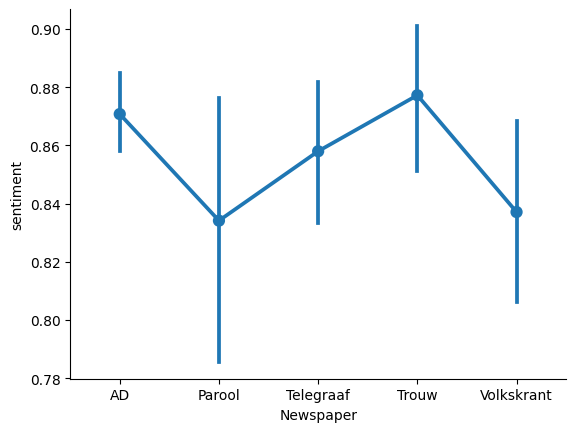

In [ ]:
import seaborn as sns

fig = sns.pointplot(x='Newspaper', y='sentiment', data=df)
sns.despine()

In [ ]:
import pingouin as pg

pg.homoscedasticity(data=df, dv='sentiment', group='Newspaper').round(2)
display(pg.anova(dv='sentiment', between='Newspaper', data=df, detailed=True))
pg.pairwise_tests(dv='sentiment', between='Newspaper', padjust='bonferroni', data=df)

,Source,SS,DF,MS,F,p-unc,np2
0,Newspaper,0.404773,4,0.101193,1.961695,0.097838,0.004244
1,Within,94.967321,1841,0.051585,NaN,NaN,NaN


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,Newspaper,AD,Parool,False,True,1.479756,154.284565,two-sided,0.140977,1.000000,bonferroni,0.3,0.168082
1,Newspaper,AD,Telegraaf,False,True,0.875311,503.981099,two-sided,0.381822,1.000000,bonferroni,0.109,0.060198
2,Newspaper,AD,Trouw,False,True,-0.427260,456.197442,two-sided,0.669392,1.000000,bonferroni,0.084,-0.030353
3,Newspaper,AD,Volkskrant,False,True,1.902634,375.556833,two-sided,0.057853,0.578529,bonferroni,0.462,0.150726
4,Newspaper,Parool,Telegraaf,False,True,-0.886086,208.533685,two-sided,0.376592,1.000000,bonferroni,0.169,-0.100021
5,Newspaper,Parool,Trouw,False,True,-1.583830,215.532646,two-sided,0.114699,1.000000,bonferroni,0.389,-0.178687
6,Newspaper,Parool,Volkskrant,False,True,-0.103010,252.937468,two-sided,0.918036,1.000000,bonferroni,0.118,-0.011047
7,Newspaper,Telegraaf,Trouw,False,True,-1.042531,583.418125,two-sided,0.297597,1.000000,bonferroni,0.156,-0.085886
8,Newspaper,Telegraaf,Volkskrant,False,True,1.013454,523.152173,two-sided,0.311312,1.000000,bonferroni,0.154,0.085748
9,Newspaper,Trouw,Volkskrant,False,True,1.911819,524.991230,two-sided,0.056444,0.564435,bonferroni,0.559,0.163265


In [ ]:
pg.welch_anova(dv='sentiment', between='Newspaper', data=df).round(2)

,Source,ddof1,ddof2,F,p-unc,np2
0,Newspaper,4,530.64,1.61,0.17,0.0
